In [30]:
! pip install densratio
! pip install --quiet numba-scipy
! pip install --upgrade scipy numba

In [1]:
# TODO

# 1.
# Make non-linear in such a way that you cannot extrapolate to unseen P(Y,X)

# 2. 
# Use importance estimation to extrapolate.

# 3. 
# Show that when H|Z vs Z|H, extrapolation fails even with importance estimation. 

# 4
# Make true model such that excluding variables should recover a model that is "robust" (P(X|H))

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from trees import TransferTreeRegressor, build_tree, Node
from criteria import mse, transfer, causal_tree_criterion
from sklearn.preprocessing import PolynomialFeatures
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [3]:
def plot_dat(vars_):
    f, axes = plt.subplots(len(vars_), 1, sharex=True, figsize=(20, 10))

    for (H,title),ax in zip(vars_, axes):
        for i,h in zip(['A', 'B', 'C', 'D'], H):
            sns.distplot(h, label = i, ax=ax)
        ax.legend()
        ax.set_title(title)
        
    # plt.title(title)
    # plt.show()

In [4]:
import numpy as np
from scipy.stats import gamma
import seaborn as sns
from copy import deepcopy

# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    val = w*h + w*z + np.random.normal(0, 2, size = h.shape[0])
    return val


def generate_data(N, fn, hidden_cause, plot, hiddens, v_conds, z_conds):
    # H is latent variable, distribution changes (not )
    H = [gamma.rvs(a, loc=b, scale=1, size=N) for a,b in hiddens]

    # V := f(H, N_X)
    V = [(1/(h))*c * np.random.gamma(a, b, size=N) for h,(c,a,b) in zip(H, v_conds)]

    # if hidden_cause: 
    # H -> V, H -> Y
    # else:
    # V -> H, H -> Y
    if not hidden_cause:
        V,H = deepcopy(H), deepcopy(V)

    # Z = [gamma.rvs(int(np.random.normal(40, 10)), loc=0, scale=1, size=N) for h in H]
    # Z := f(N_Z) 
    Z = [gamma.rvs(a, loc=l, scale=s, size=N) for h,(a,l,s) in zip(H, z_conds)]

    # W := f(N_W) -- TREATMENT
    W = [np.random.binomial(1, 0.5, size=N) for h in H]

    # Y:= fn(H, V, Z, W, N_Y)
    Y = [fn(H[idx], V[idx], Z[idx], W[idx]) for idx in range(4)]

    taus = [fn(h,v,z,1) - fn(h,v,z,0) for h,v,z in zip(H,V,Z)]
    
    if plot:
        plot_dat([(H,'H'), (V, 'V') , (Z, 'Z'), (Y, 'Y'), (taus, 'tau')])

    return [(y, np.array([w,v,z]).T, tau) for y,v,z,w,h,tau in zip(Y, V, Z, W, H, taus)]

In [292]:
from sklearn.metrics import mean_squared_error
from numba import njit


def flatten(a):
    return np.array([y for x in a for y in x])


def split_out_dat(dat):
    phi = PolynomialFeatures(degree=1, include_bias=False).fit_transform
    ys, Xs, taus = zip(*dat)

    ys_source, Xs_source = np.concatenate(ys[:-1]), np.concatenate(Xs[:-1])
    ys_target, Xs_target = ys[-1], Xs[-1]

    phi_source = phi(Xs_source[:, 1:])
    phi_target = phi(Xs_target[:, 1:])

    treatment = Xs_source[:, 0]
    N = ys[0].shape[0]

    context_idxs = np.array([j for i,_ in enumerate(ys[:-1]) for j in [i]*N])

    idx = np.arange(phi_source.shape[0])
    np.random.shuffle(idx)

    # print(phi_source.shape)
    # print(ys_source.shape)
    # print(treatment.shape)
    # print(context_idxs.shape)

    phi_source = phi_source[idx, :]
    ys_source = ys_source[idx]
    treatment = treatment[idx]
    context_idxs = context_idxs[idx]
    taus_source, taus_target = flatten(taus[:-1])[idx], taus[-1]

    return phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target

def fit_models(phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target):
    causal_model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              max_depth = 5, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    causal_model.fit(phi_source, 
                     ys_source, 
                     treatment=treatment,
                     min_samples=25,
                     var_weight=0.5)

    # causal_model.set_best_tree()
    causal_model.tree = causal_model.tree_path[0][1]

    transfer_model = TransferTreeRegressor(criterion = transfer,
                              max_depth = 5, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    transfer_model.fit(phi_source, 
                       ys_source, 
                       treatment=treatment,
                       context_idxs=context_idxs, 
                       target_X=phi_target,
                       min_samples=25,
                       tau_var_weight=10.0,
                       tau_var_var_weight=10.0,
                       importance=False)

    # transfer_model.set_best_tree()
    # transfer_model.tree
    transfer_model.tree = transfer_model.tree_path[0][1]

    tpreds = transfer_model.predict(phi_target)
    cpreds = causal_model.predict(phi_target)

    return (mean_squared_error(taus_target, tpreds), mean_squared_error(taus_target, cpreds)), (tpreds, cpreds), (transfer_model, causal_model), (phi_source, phi_target, taus_target)
    

In [293]:
# hiddens = [(25, 2), (4, 15), (4, 20)flatten(taus[:-1]), (2, 20)]
hiddens = [(10,2)]*4
# v_conds = [(500, 2, 2)]*4 # implies that H|V (or V|H if hidden_cause) is constant
# z_conds = [(3, 1, 4), (4, 2, 4), (10, 1, 3), (4, 4, 4)]
# v_conds = [(6,2,5), (6,5,5), (8,2,10), (-3,2,8)]

z_conds = [(3, 1, 4), (3, 1, 4), (3, 1, 4), (4, 4, 4)]
v_conds = [(6,2,5), (6,2,5), (6,2,5), (-3,2,8)]


def runrun(N):
    dat = generate_data(N,
                        fn, 
                        hidden_cause = True, 
                        plot = False, 
                        hiddens = hiddens,
                        v_conds = v_conds, 
                        z_conds = z_conds)

    return fit_models(*split_out_dat(dat))

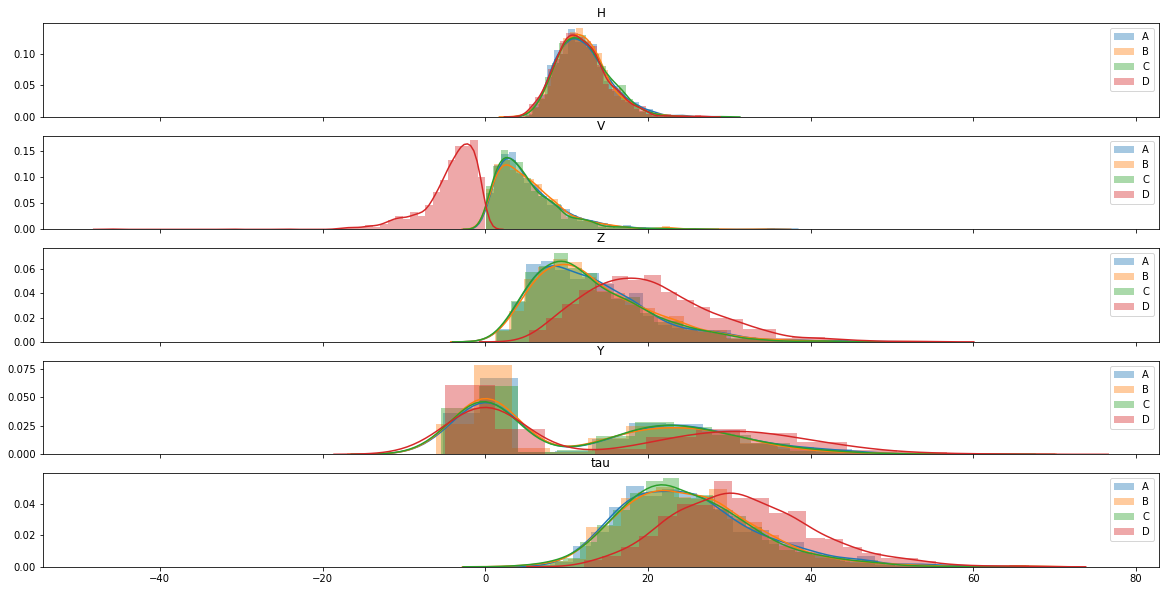

In [294]:
dat = generate_data(1000,
                    fn, 
                    hidden_cause = True, 
                    plot = True, 
                    hiddens = hiddens,
                    v_conds = v_conds, 
                    z_conds = z_conds)


In [295]:
ys, Xs, taus = zip(*dat)
phi_source, phi_target, _, _, _, taus_source, taus_target = split_out_dat(dat)

from sklearn.linear_model import LinearRegression

LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

LinearRegression().fit(Xs[0], taus[0]).coef_, LinearRegression().fit(Xs[1], taus[1]).coef_, LinearRegression().fit(Xs[2], taus[2]).coef_, LinearRegression().fit(Xs[3], taus[3]).coef_

(array([ 0.19541081, -0.26878852,  1.0169517 ]),
 array([ 0.13033064, -0.23232078,  1.01722685]),
 array([-0.27768885, -0.21296318,  1.02825401]),
 array([0.22317178, 0.25411563, 0.99177342]))

In [296]:
scores, preds, models, datt = runrun(500)
tt, ct = models

In [297]:
tt.tree

|--dim: 1, thresh: 19.4020 score: -268.7943, gain: 17.8091, tot_gain: 7.3688 
   |--dim: 1, thresh: 7.3496 score: -185.6747, gain: 6.3318, tot_gain: -10.4403 
      |--dim: 1, thresh: 5.5082 score: -20.5569, gain: -5.4589, tot_gain: -5.4589 
         |--pred: 15.8036, score: -7.6671, N: 72 
         |--pred: 18.1282, score: -7.4308, N: 80 
      |--dim: 1, thresh: 16.0974 score: -171.4497, gain: 0.0533, tot_gain: -11.3132 
         |--dim: 0, thresh: 6.8054 score: -127.7502, gain: -1.1983, tot_gain: -11.3665 
            |--dim: 1, thresh: 11.8880 score: -98.2005, gain: -7.7952, tot_gain: -7.7952 
               |--pred: 22.3020, score: -45.5706, N: 169 
               |--pred: 26.0079, score: -44.8347, N: 111 
            |--dim: 1, thresh: 11.2838 score: -28.3515, gain: -2.3731, tot_gain: -2.3731 
               |--pred: 19.2581, score: -9.4963, N: 57 
               |--pred: 22.5515, score: -16.4820, N: 58 
         |--pred: 29.6921, score: -43.7527, N: 82 
   |--pred: 36.2109, scor

In [298]:
ct.tree

|--dim: 1, thresh: 13.2092 score: -306.5806, gain: 8.4183, tot_gain: 15.6221 
   |--dim: 1, thresh: 8.0457 score: -128.0119, gain: 1.4625, tot_gain: 1.9019 
      |--dim: 1, thresh: 6.1525 score: -41.1041, gain: -0.4064, tot_gain: -0.4064 
         |--pred: 15.8877, score: -16.0921, N: 96 
         |--pred: 19.1336, score: -24.6056, N: 101 
      |--dim: 0, thresh: 7.8596 score: -88.3703, gain: 0.6997, tot_gain: 0.8458 
         |--dim: 1, thresh: 11.5555 score: -73.4438, gain: 0.1071, tot_gain: 0.1460 
            |--dim: 1, thresh: 9.5512 score: -48.8470, gain: 0.0389, tot_gain: 0.0389 
               |--pred: 21.3236, score: -18.4483, N: 61 
               |--pred: 23.9100, score: -30.4376, N: 80 
            |--pred: 24.6813, score: -24.7040, N: 61 
         |--pred: 20.1266, score: -15.6262, N: 58 
   |--dim: 1, thresh: 19.4020 score: -186.9870, gain: 4.4349, tot_gain: 5.3019 
      |--dim: 1, thresh: 14.8987 score: -85.7528, gain: 0.6383, tot_gain: 0.8671 
         |--pred: 24.37

In [299]:
imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

imp(tt, ct)

-0.03569611235497672

0.05336862303269546
-0.013789896634844959


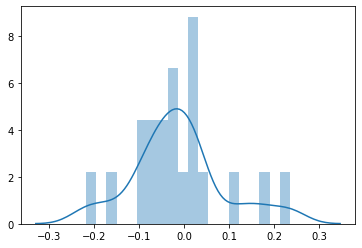

In [301]:
# N = 500

imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

results = [runrun(500) for i in range(20)]
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
importances = [imp(tt, ct) for (t,c),_,(tt, ct),_ in results]
print(np.mean(importances))
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

In [302]:
import pandas as pd

pd.DataFrame(np.array([importances, mse]).T).corr()

,0,1
0,1.000000,0.027123
1,0.027123,1.000000


In [ ]:
tt, ct = results[4][2]
tt.tree

In [ ]:
%%time
# N = 1000

results = Parallel(n_jobs=-1)(delayed(runrun)(1000) for i in range(4))
results = [(t-c)/c for (t,c),_,_,_ in results]
print(np.mean(results))
sns.distplot(np.array(results))

-0.00667778248444865
CPU times: user 506 ms, sys: 32 ms, total: 538 ms
Wall time: 56.5 s


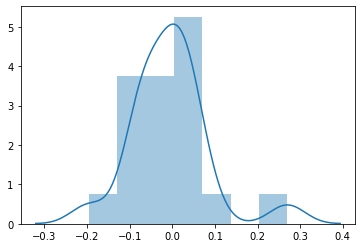

In [20]:
%%time
# N = 2000

results = [runrun(2000) for i in range(20)]
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
importances = [imp(tt, ct) for (t,c),_,(tt, ct),_ in results]
print(np.mean(importances))
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

In [674]:
# R2 score of predictions
cpreds = [causal_model.predict(phi(x[:, 1:])) for x in Xs]

[r2_score(t,p) for p,t in zip(cpreds, taus)]

[0.4811299367925779,
 0.5438726948713652,
 0.5587077923339808,
 0.48189930734850306]

In [675]:
# R2 score of predictions

tpreds = [transfer_model.predict(phi(x[:, 1:])) for x in Xs]

[r2_score(t,p) for p,t in zip(tpreds, taus)]

[0.48204475644637146,
 0.540050801439888,
 0.587036531032876,
 0.47988350972769966]

In [ ]:
[np.mean((t-p)**2) for p,t in zip(preds, taus)]

In [475]:
# Score of oracle average of sources on target

np.mean((np.mean(taus[:-1]) - taus[-1])**2)

1.6767703616462597

In [89]:
# score of oracle ATE from same source

[np.mean((np.mean(t) - t)**2) for t in taus]

[1511.704608424898, 3322.551749217693, 1561.6842105276883, 1085.0911237975392]

# Causal Tree Test

In [11]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [12]:
import pandas as pd


def get_simulation(fi = 'simulation-1-athey.csv'):
    df = pd.read_csv(fi)
    X = df.iloc[:, :4].values
    y = df.y.values
    treatment = df.treatment.values
    return X, y, treatment

sim_X, sim_y, sim_treatment = get_simulation()

In [13]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [62]:
def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01, size = X.shape[0])


N = 12000
S = 2000
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
weights = np.ones(N)
y = gen_y(X, treatment)

In [63]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [64]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [65]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

CPU times: user 90.3 ms, sys: 27.6 ms, total: 118 ms
Wall time: 15.9 s


{'alpha': -0.01, 'honest': True}

In [101]:
from sklearn.metrics import r2_score

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

# model.set_params(**best_params)
model.set_params(alpha = 0.0, honest=True)

model.fit(X[:S], y[:S], treatment=treatment[:S], min_samples=25, var_weight = 0.5)

print(r2_score(kappa(X[S:]), model.predict(X[S:])))

model.tree

0.41312961688576955


|--dim: 0, thresh: 0.9748, score: -0.1898, gain: 0.2114, tot_gain: 0.3160 
   |--dim: 3, thresh: -0.2668, score: -0.0293, gain: 0.0499, tot_gain: 0.1045 
      |--dim: 1, thresh: 0.2870, score: 0.0001, gain: 0.0097, tot_gain: 0.0174 
         |--pred: 0.0246, score: 0.0126, N: 202 
         |--dim: 4, thresh: 0.1007, score: -0.0222, gain: 0.0077, tot_gain: 0.0077 
            |--pred: 1.0202, score: -0.0227, N: 66 
            |--pred: 0.8655, score: -0.0072, N: 56 
      |--dim: 4, thresh: -0.9703, score: -0.0793, gain: -0.0133, tot_gain: 0.0373 
         |--pred: 0.3458, score: 0.0057, N: 81 
         |--dim: 1, thresh: -0.2146, score: -0.0716, gain: 0.0302, tot_gain: 0.0506 
            |--dim: 2, thresh: 0.6212, score: 0.0126, gain: 0.0127, tot_gain: 0.0127 
               |--pred: 0.4813, score: -0.0062, N: 154 
               |--pred: -0.4445, score: 0.0061, N: 48 
            |--dim: 5, thresh: 0.4866, score: -0.1144, gain: 0.0078, tot_gain: 0.0078 
               |--pred: 1.242

In [102]:
preds = pd.DataFrame(model.predict(X[S:], interval = 0.975), columns = ['pred', 'lower', 'upper'])

preds.assign(true = kappa(X[S:])) \
    .groupby('pred') \
    .apply(lambda df: df.assign(true_cate = df.true.mean())) \
    .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
    .pipe(lambda df: df['within_int'].sum() / df.shape[0])

1.0

In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 